<a href="https://colab.research.google.com/github/mikful/dlai-tf-in-practice/blob/master/TensorFlow_in_Practice_Course_4_S%2BP_Week_2_Lesson_2_Single_Layer_NN_with_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Layer NN Regression Model for Time Series data

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)


# Split at the split time
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


# Setup constants for the Single layer NN
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Function to create a windowed dataset
# Takes in a data series, window size and batch size and shuffle and creates a windowed dataset

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # Create dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # Slice the data up into windows, each one shifted by one time step, drop remainder to standardize size
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flatten the data to window size + 1
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # shuffle the data - shuffle buffer speeds up - if you have 100,000 items and set to 1000, will fill with first 1000 elements, pick one at random, then replace that the 1001 element before randomly picking again and so on - so speeds things up by effectively choosing from smaller data sample
  # map lambda function splits the suffled data into the x (all but last) and y (last) data items
  dataset = dataset.batch(batch_size).prefetch(1) # The data is then batched and returned
  return dataset 

In [0]:
# Create windowed dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)

# Create Single Layer NN
  # assign layer to object in order to print out learned weights layer
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) # input shape = window size
model = tf.keras.models.Sequential([l0])

# Compile and train the model
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum =0.9))
#model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
model.fit(dataset,epochs=100,verbose=2)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/100
31/31 - 0s - loss: 3345.7479
Epoch 2/100
31/31 - 0s - loss: 335.9129
Epoch 3/100
31/31 - 0s - loss: 128.9101
Epoch 4/100
31/31 - 0s - loss: 115.1596
Epoch 5/100
31/31 - 0s - loss: 107.0382
Epoch 6/100
31/31 - 0s - loss: 103.2129
Epoch 7/100
31/31 - 0s - loss: 96.5614
Epoch 8/100
31/31 - 0s - loss: 92.6626
Epoch 9/100
31/31 - 0s - loss: 89.7424
Epoch 10/100
31/31 - 0s - loss: 89.8514
Epoch 11/100
31/31 - 0s - loss: 85.0416
Epoch 12/100
31/31 - 0s - loss: 82.2971
Epoch 13/100
31/31 - 0s - loss: 80.7096
Epoch 14/100
31/31 - 0s - loss: 78.8858
Epoch 15/100
31/31 - 0s - loss: 76.0776
Epoch 16/100
31/31 - 0s - loss: 74.5906
Epoch 17/100
31/31 - 0s - loss: 72.9506
Epoch 18/100
31/31 - 0s - loss: 72.6802
Epoch 19/100
31/31 - 0s - loss: 69.8300
Epoch 20/100
31/31 - 0s - loss: 68.9584
Epoch 21/100
31/31 - 0s - loss: 68.3290
Epoch 22/100
31/31 - 0s - loss: 66.6622
Epoch 23/100
31/31 - 0s - loss: 65.5006

In [0]:
# Inspect the layer weights 
# first array has 20 weights - each value is weights for the 20 nodes (same as input)
# second array has 1 bias term for the layer
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.02881221],
       [ 0.00067277],
       [ 0.00518323],
       [ 0.0081747 ],
       [-0.02620612],
       [ 0.11298777],
       [-0.07181022],
       [-0.0122409 ],
       [ 0.00148435],
       [ 0.01166119],
       [ 0.03175369],
       [-0.05683012],
       [-0.06183011],
       [ 0.08835977],
       [ 0.07438035],
       [ 0.0057574 ],
       [ 0.04038026],
       [ 0.11032983],
       [ 0.36390826],
       [ 0.39779386]], dtype=float32), array([0.01840088], dtype=float32)]


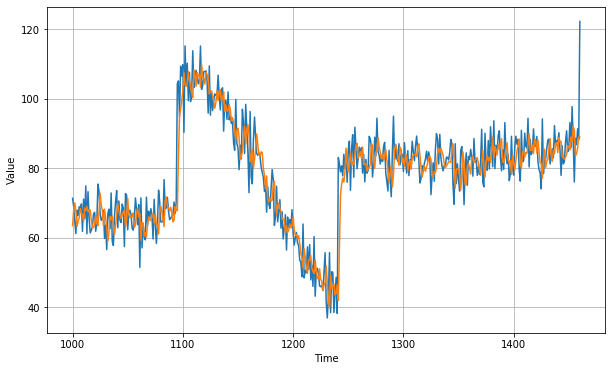

In [0]:
# Predict the next values

forecast = [] # empty list

# Iterate over the data by passing in a window size of data and predicting the next value
# Do a standard linear regression to get the result: Y = W0*X0 +.... W19*X19 + b
# add to list
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# As data was split into train/valid, take the valid data after the split time to forecast it
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.111128